### Imports

In [1]:
# Standard library imports
import os
import sys
import warnings

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import mat73
import rpy2.robjects as robjects
from scipy.signal import butter, find_peaks, lfilter
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Local imports
from src.features.preprocessing import *
from src.visualization.data_vis import *

# Notebook magic
%matplotlib inline

Unable to determine R home: [WinError 2] The system cannot find the file specified
Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.1\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


### Preprocessing parameters

In [55]:
# Filter 
filter_order = 2
theta_sampling_freq = 1250
lowcut = 6 / (theta_sampling_freq*0.5)
highcut = 12 / (theta_sampling_freq*0.5)

# Theta epoch extraction
trial_duration = 4 # seconds
trial_N = int(theta_sampling_freq*trial_duration) # Number of data points in each trial based on theta sampling frequency

# KDE  
bandwidth = 0.02
kde_domain = [0, 4]
cut = 3
kde_domain_N = trial_N

# DFA 
DFA_window = 0.5 # seconds

### Data preprocessing

In [73]:
# Takes 17m on laptop, ~1GB total mem

for j, file_name in enumerate([
    "fitted_data_mjc57-1212-0110.mat"]):
    #"fitted_data_mjc58-2301-0117.mat",
    #"fitted_data_mjc65-2704-0114.mat",
    #"fitted_data_mjc66-1205-0116.mat",
    #"fitted_data_mjc67-1006-0114.mat"
    #]):

    # Load the file
    file_data = mat73.loadmat('/'.join([os.getcwd(), 'data', 'raw', file_name]))

    # Assign spike data constructs
    qspike = file_data['qspike'] # trial spike times aligned to maximize likelihood estimate
    pyrspike = file_data['pyrspike'] # all pyramidal spike times and labels
    intspike = file_data['intspike'] # all interneuron spike times and labels

    # Assign theta LFP vectors
    theta = file_data['lfp']
    theta_time_axis = file_data['time_eeg']

    # Determine indices in theta_time_axis where each trial begins
    trial_shifts = (file_data['BP']*file_data['fs2']).astype(int)
    unshifted_trial_start_indices = (file_data['tp']*file_data['fs2']).astype(int)
    trial_start_indices = unshifted_trial_start_indices + trial_shifts

    # Extract relevant structures
    pyr_com_trials, pyr_sep_trials, pyr_com_neuron_labels, pyr_sep_neuron_labels, pyr_sep_trial_labels = prep_pyr_qspike(qspike, intspike, pyrspike)

    # Create and apply Butterworth bandpass filter
    b, a = butter(filter_order, [lowcut, highcut], btype='band') # The IIR
    theta_filtered = lfilter(b, a, theta) # Apply the filter

    trial_theta_x = np.zeros((trial_start_indices.size, trial_N), dtype=float) # Columns are data, rows are different trials
    trial_theta_y = np.zeros((trial_start_indices.size, trial_N), dtype=float) # Columns are data, rows are different trials

    # Extract complete epochs
    for trial_i, start_i in enumerate(trial_start_indices):
        trial_theta_x[trial_i, :] = theta_time_axis[start_i:start_i + trial_N]
        trial_theta_y[trial_i, :] = theta_filtered[start_i:start_i + trial_N]

    # Boolean classification vector
    onehot_vector = np.zeros((len(pyr_sep_trials), 2), dtype=int)
    file_kde_y = np.empty((len(pyr_sep_trials), trial_N), dtype=float)
    file_theta_y = np.empty((len(pyr_sep_trials), trial_N), dtype=float)

    # Iterate over each individual trial
    for i, trial_data in enumerate(pyr_sep_trials):
        
        trial_i = int(pyr_sep_trial_labels[i] - 1) # Trial index is one less than trial label
        active_domain_dur = (trial_data[-1] + cut*bandwidth) - (trial_data[0] - cut*bandwidth)
        active_domain_N = int(file_data['fs2']*active_domain_dur)

        kde_x, kde_y = r_spike_kde([trial_data], bandwidth, kde_domain_N, kde_domain)

        detuning = dominant_frequency_analysis(
            kde_y[0],
            trial_theta_x[trial_i, :],
            trial_theta_y[trial_i, :],
            DFA_window,
            file_data['fs2']
        )

        # Change classification from default when appropriate
        if detuning > 0:
            onehot_vector[i, 0] = 1
        else:
            onehot_vector[i, 1] = 1
        
        # Store trial data
        file_kde_y[i, :] = kde_y[0]
        file_theta_y[i, :] = trial_theta_y[trial_i, :]

    # Initialize and then concatenate data across files
    if j == 0:
        trial_kde = file_kde_y
        trial_theta = file_theta_y
        trial_labels = onehot_vector
    else:
        trial_kde = np.concatenate((trial_kde, file_kde_y), axis=0)
        trial_theta = np.concatenate((trial_theta, file_theta_y), axis=0)
        trial_labels = np.concatenate((trial_labels, onehot_vector), axis=0)

Pyramidal neurons [20.0, 23.0, 29.0, 58.0, 62.0, 63.0] absent from qspike.


### Model Hyperparameters

In [43]:
test_prop = 0.2
test_train_seed = 196883

In [76]:
# Downsample and copy data
downsample_coefficient = 4
X_kde = trial_kde[:, ::downsample_coefficient] # 1250 -> 625 Hz
X_theta = trial_theta[:, ::downsample_coefficient] # 1250 -> 625 Hz
Y = trial_labels
fs = int(X_kde.shape[1]/trial_duration)

for trial_row in range(X_kde.shape[0]):
    X_kde[trial_row, :] = (X_kde[trial_row, :]/np.amax(X_kde[trial_row, :]))

### Format data

Neuron: 33.0, Label: Null
Trial: 1.0


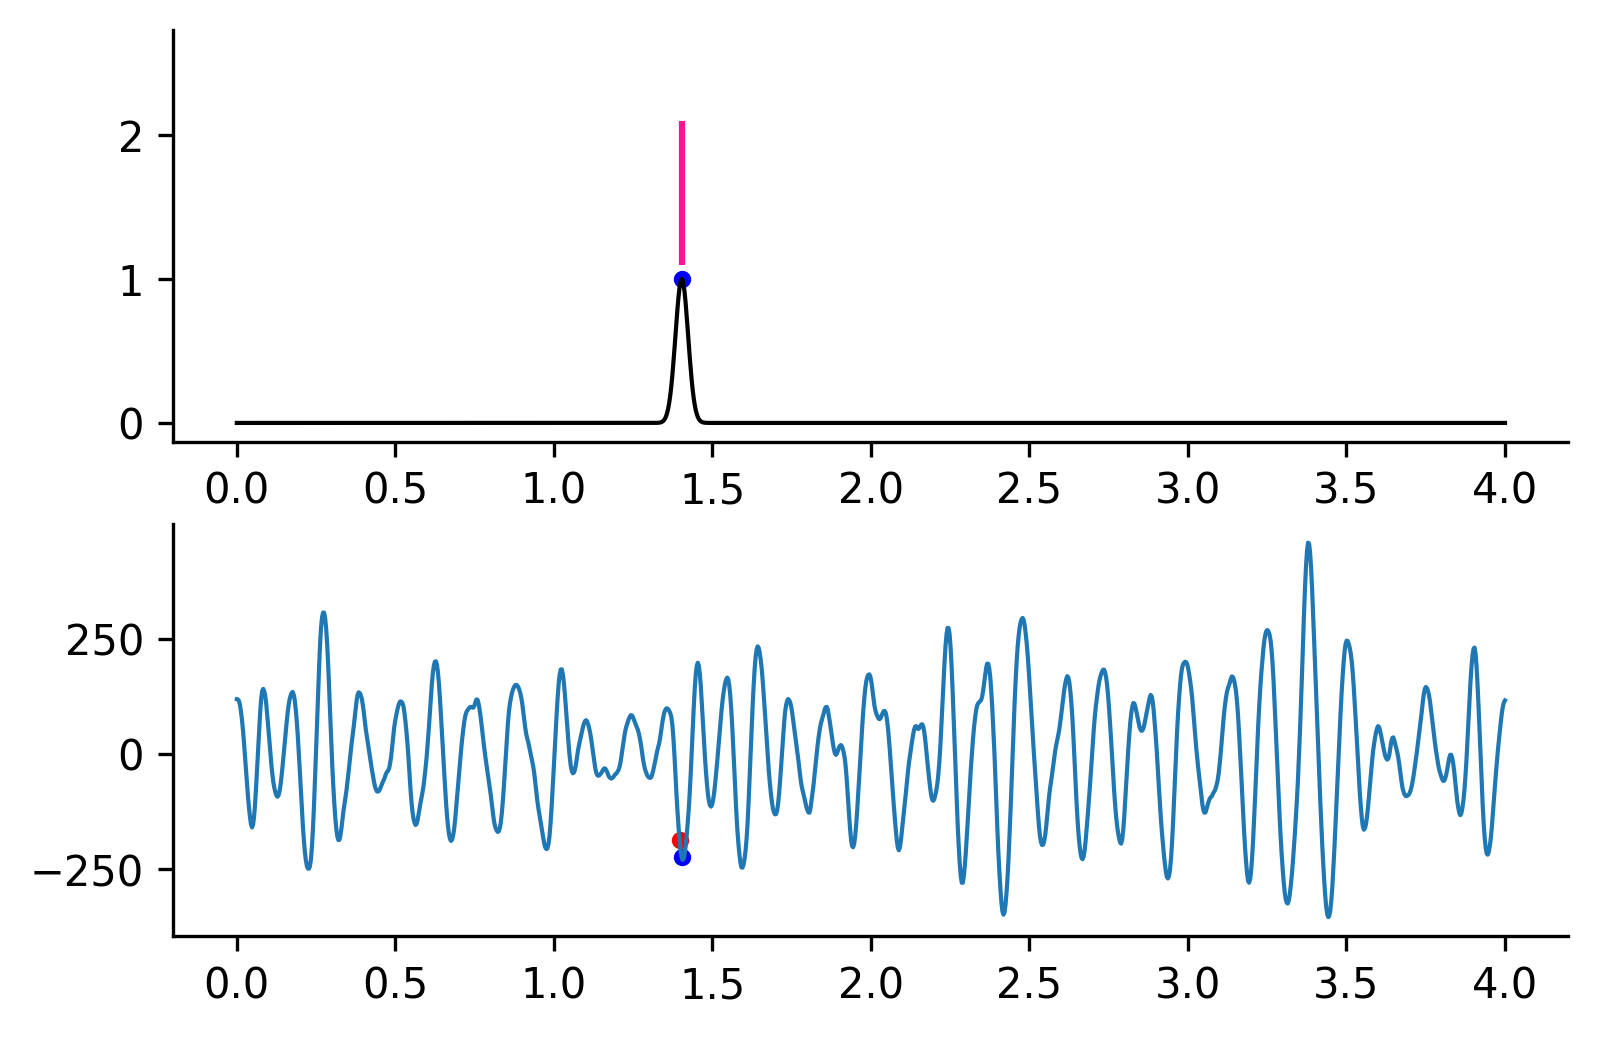

Neuron: 33.0, Label: Precession
Trial: 2.0


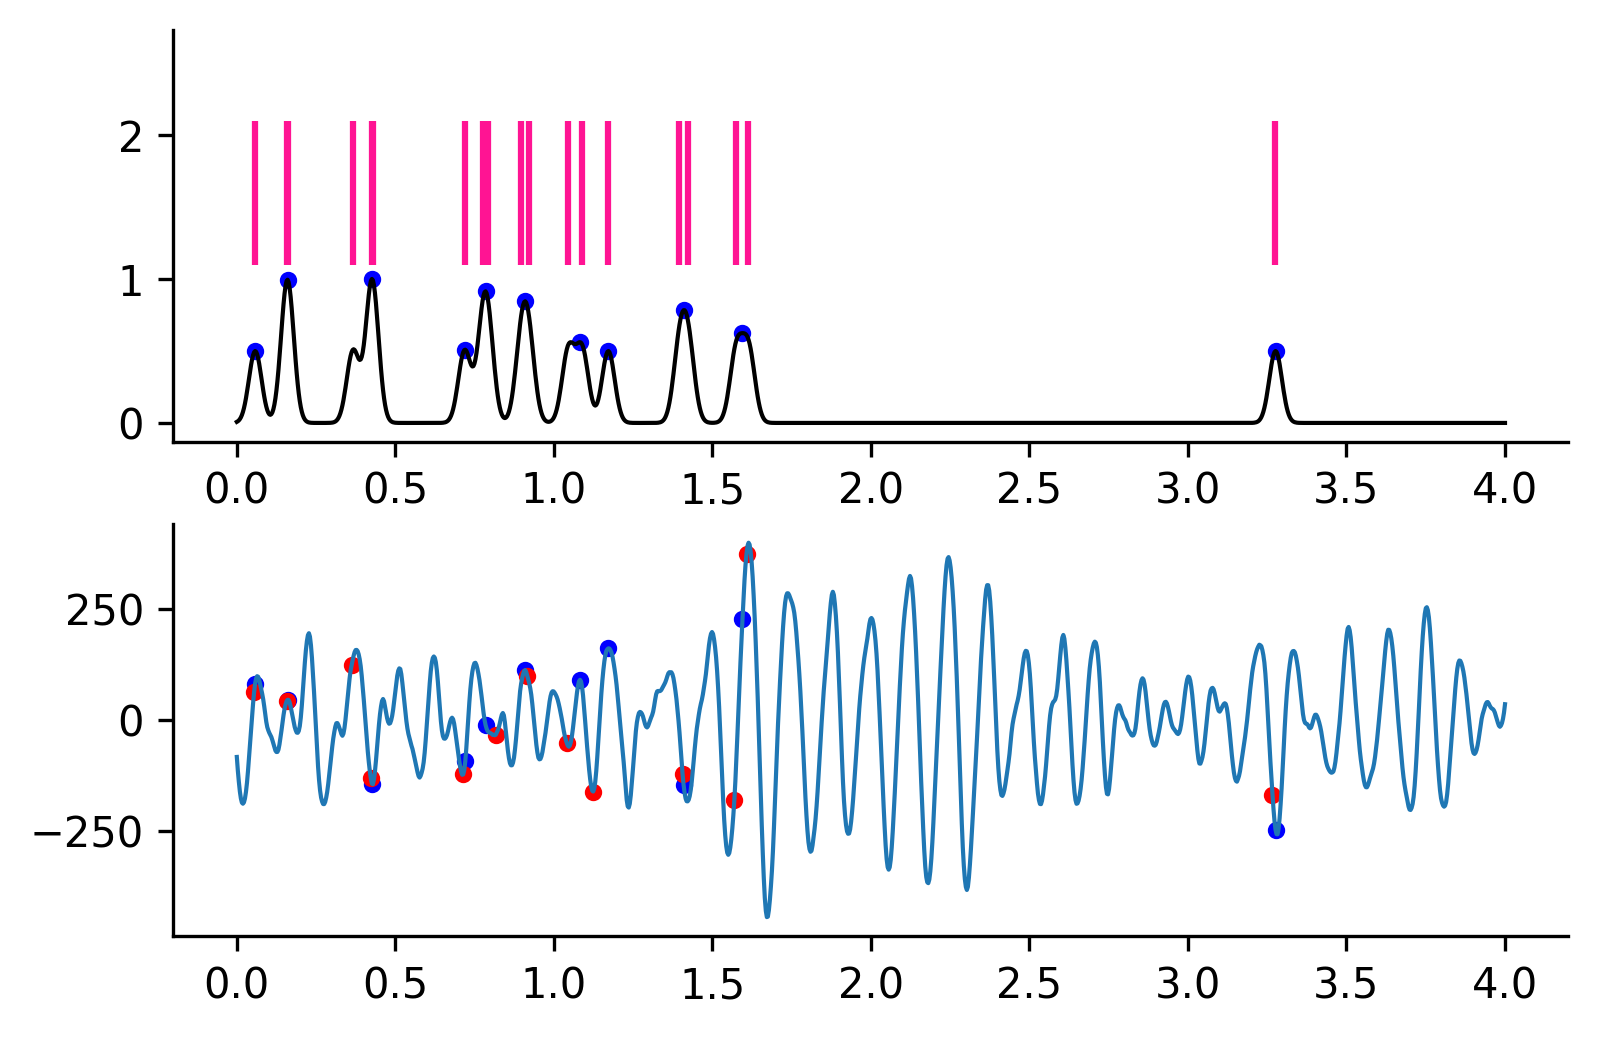

Neuron: 33.0, Label: Null
Trial: 3.0


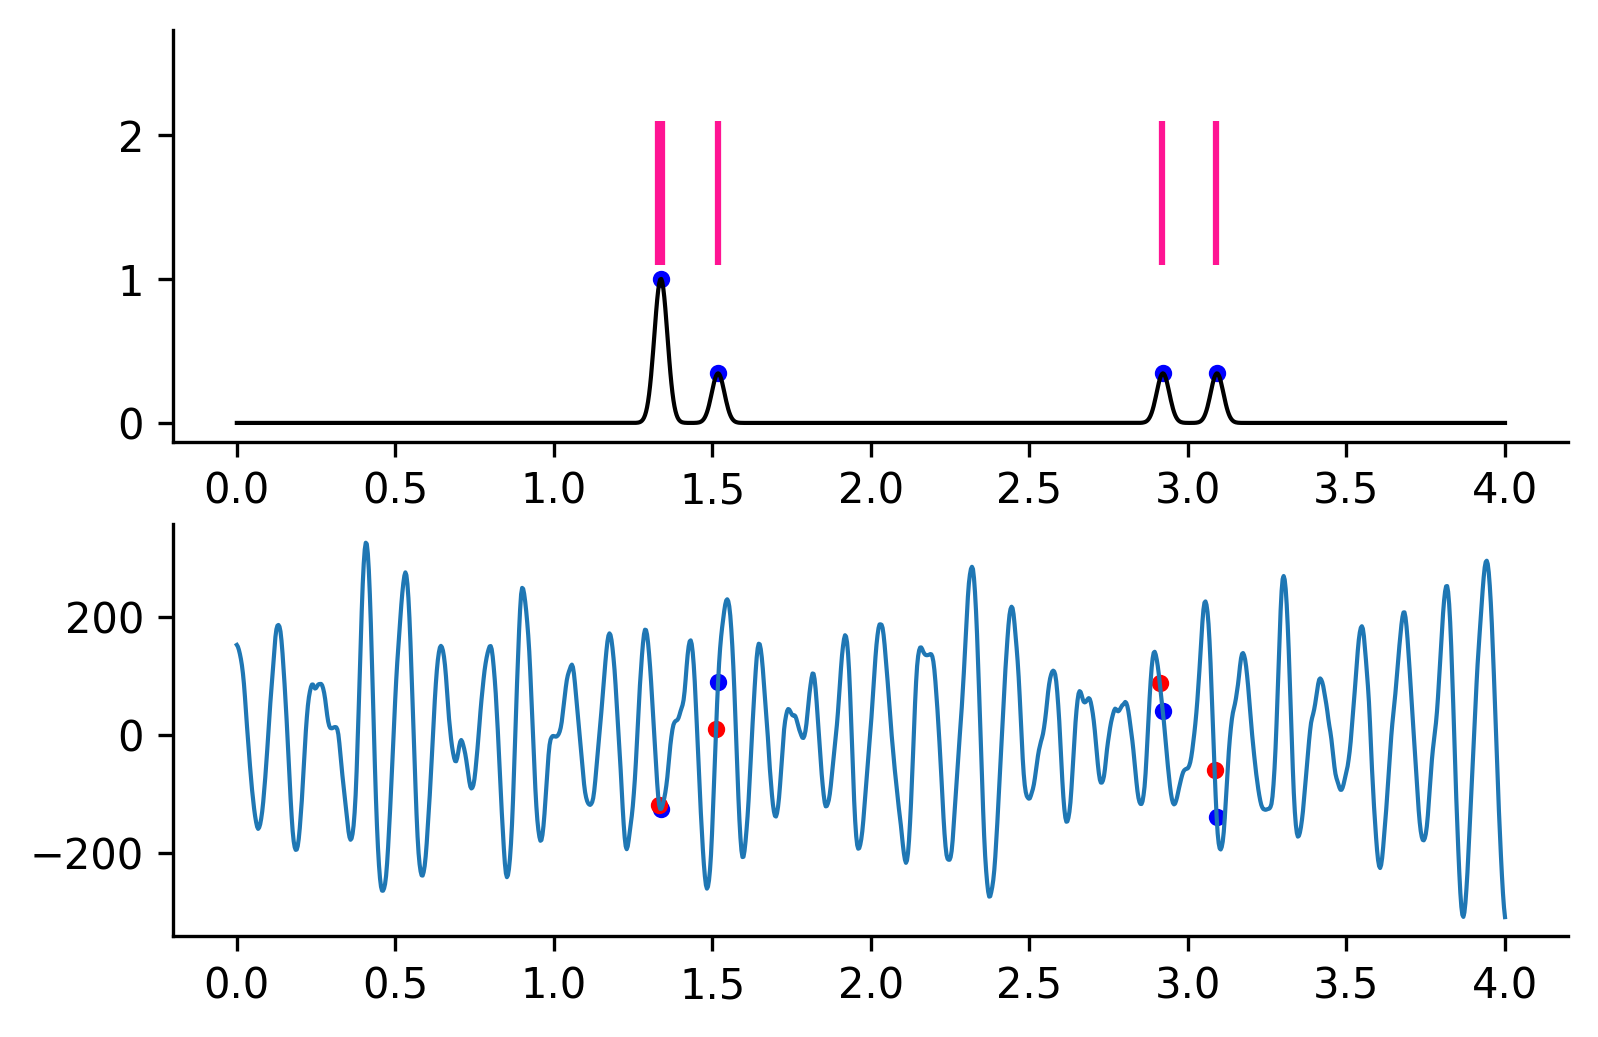

Neuron: 33.0, Label: Null
Trial: 4.0


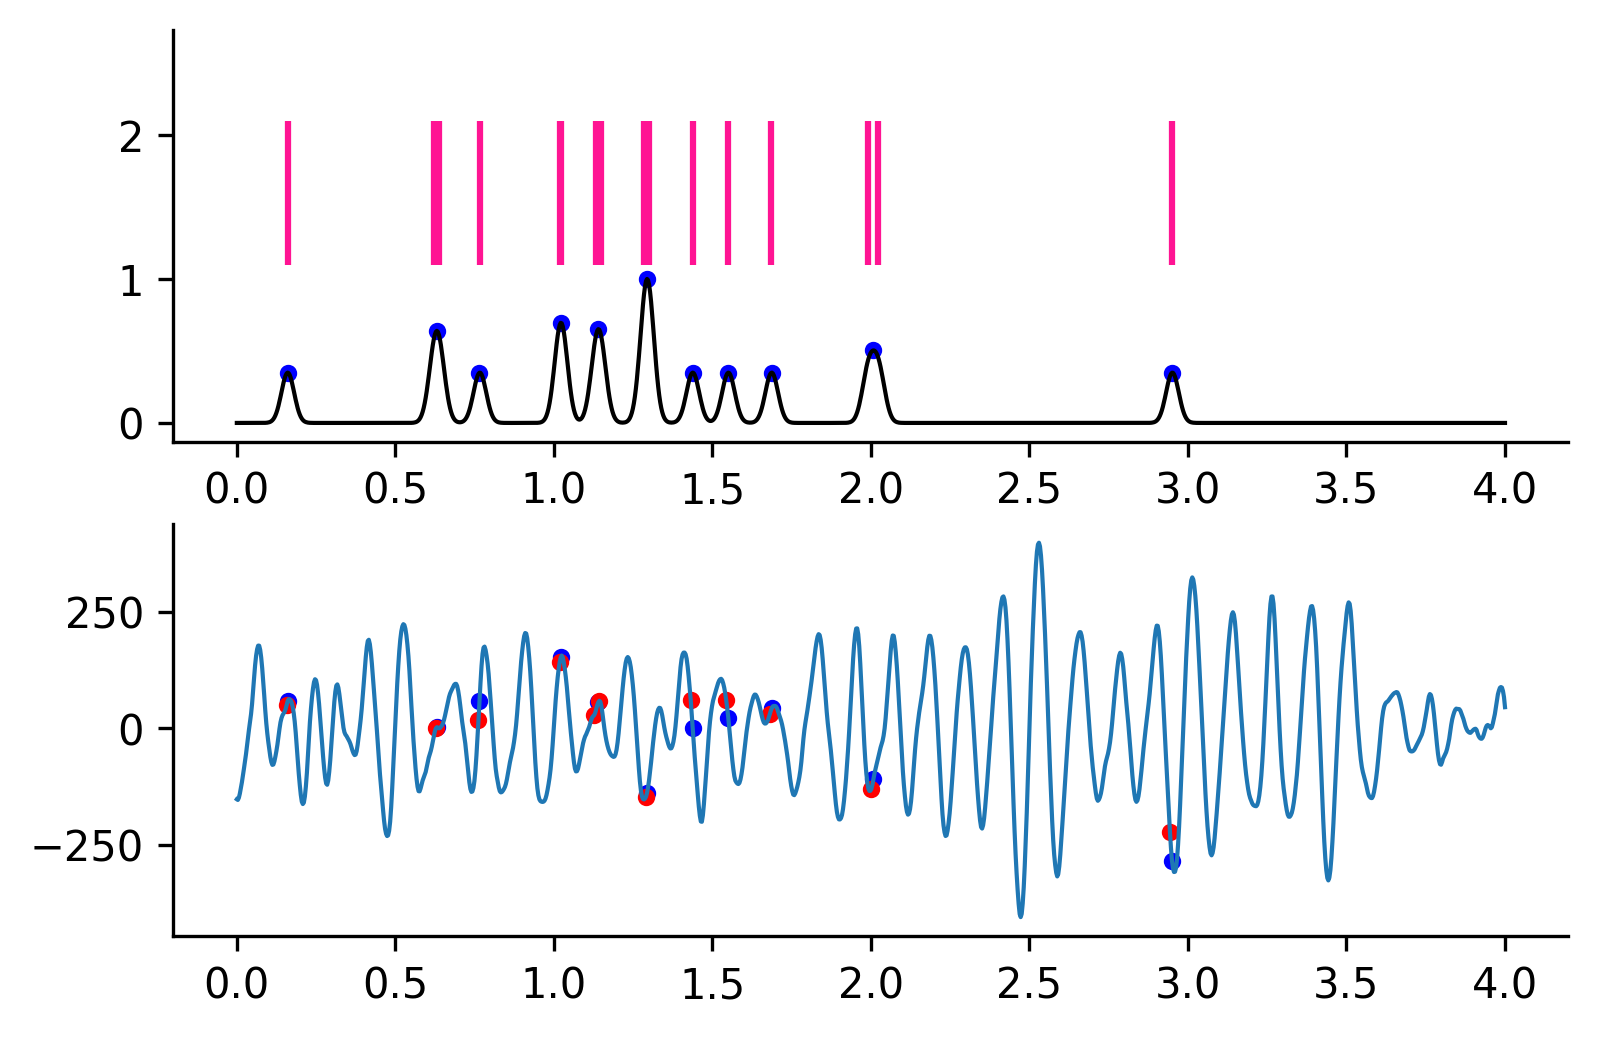

Neuron: 33.0, Label: Null
Trial: 5.0


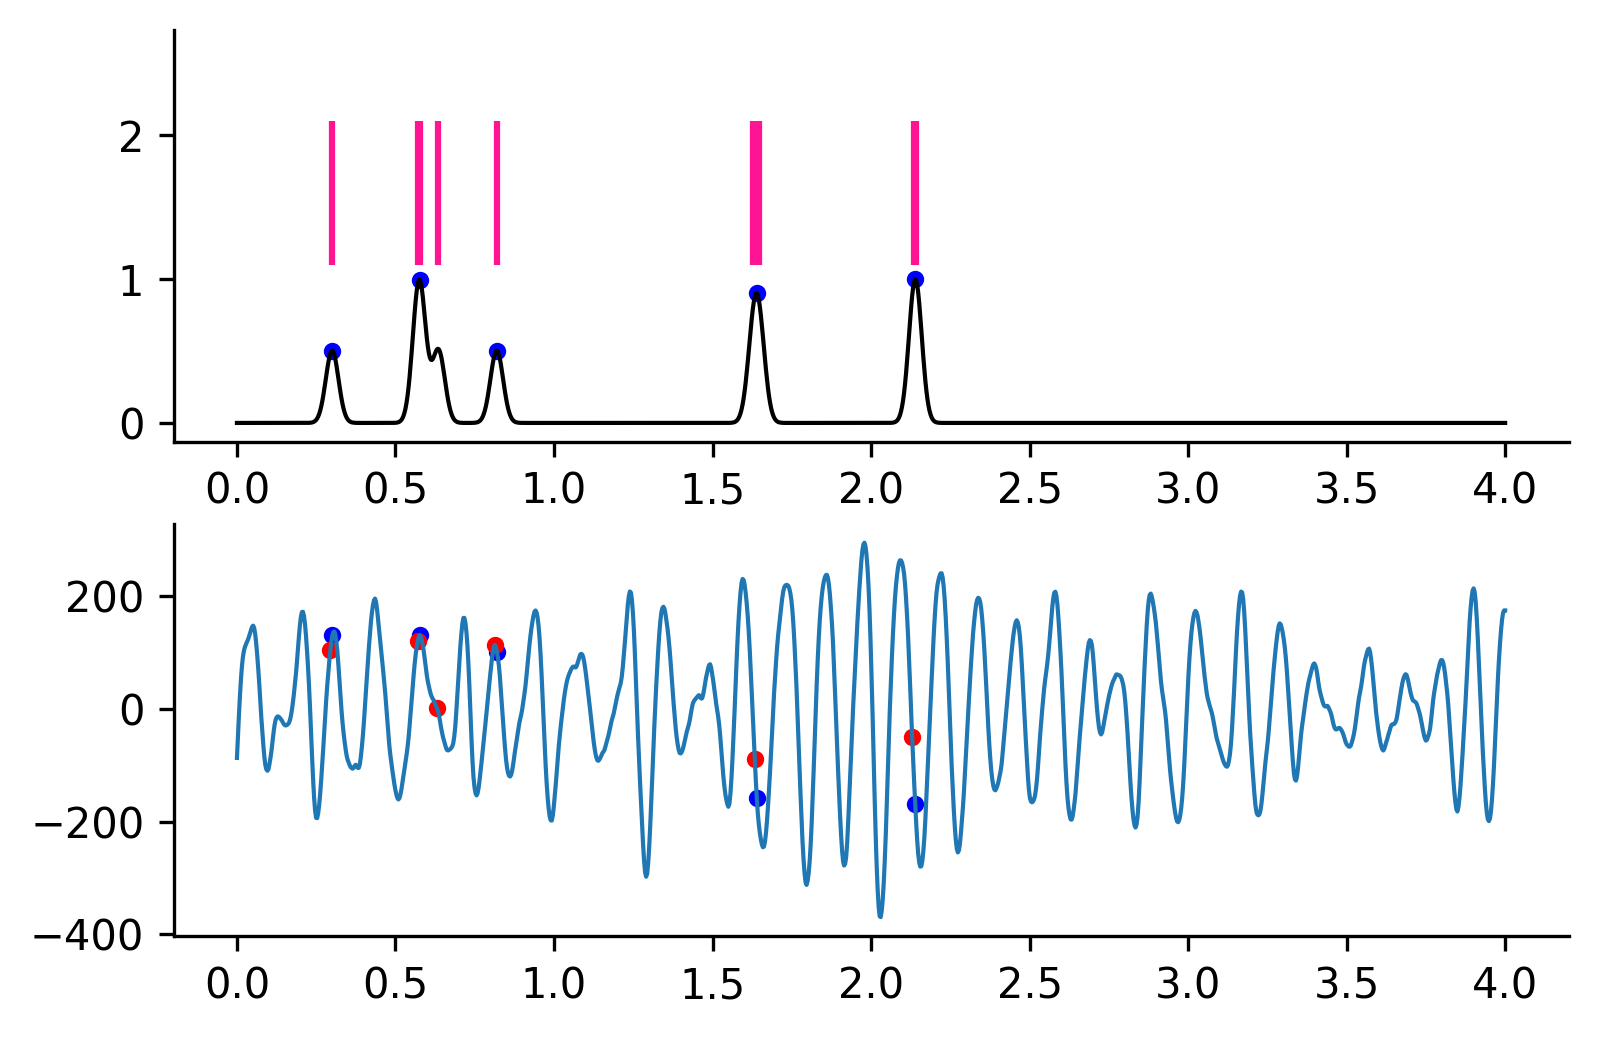

Neuron: 33.0, Label: Null
Trial: 6.0


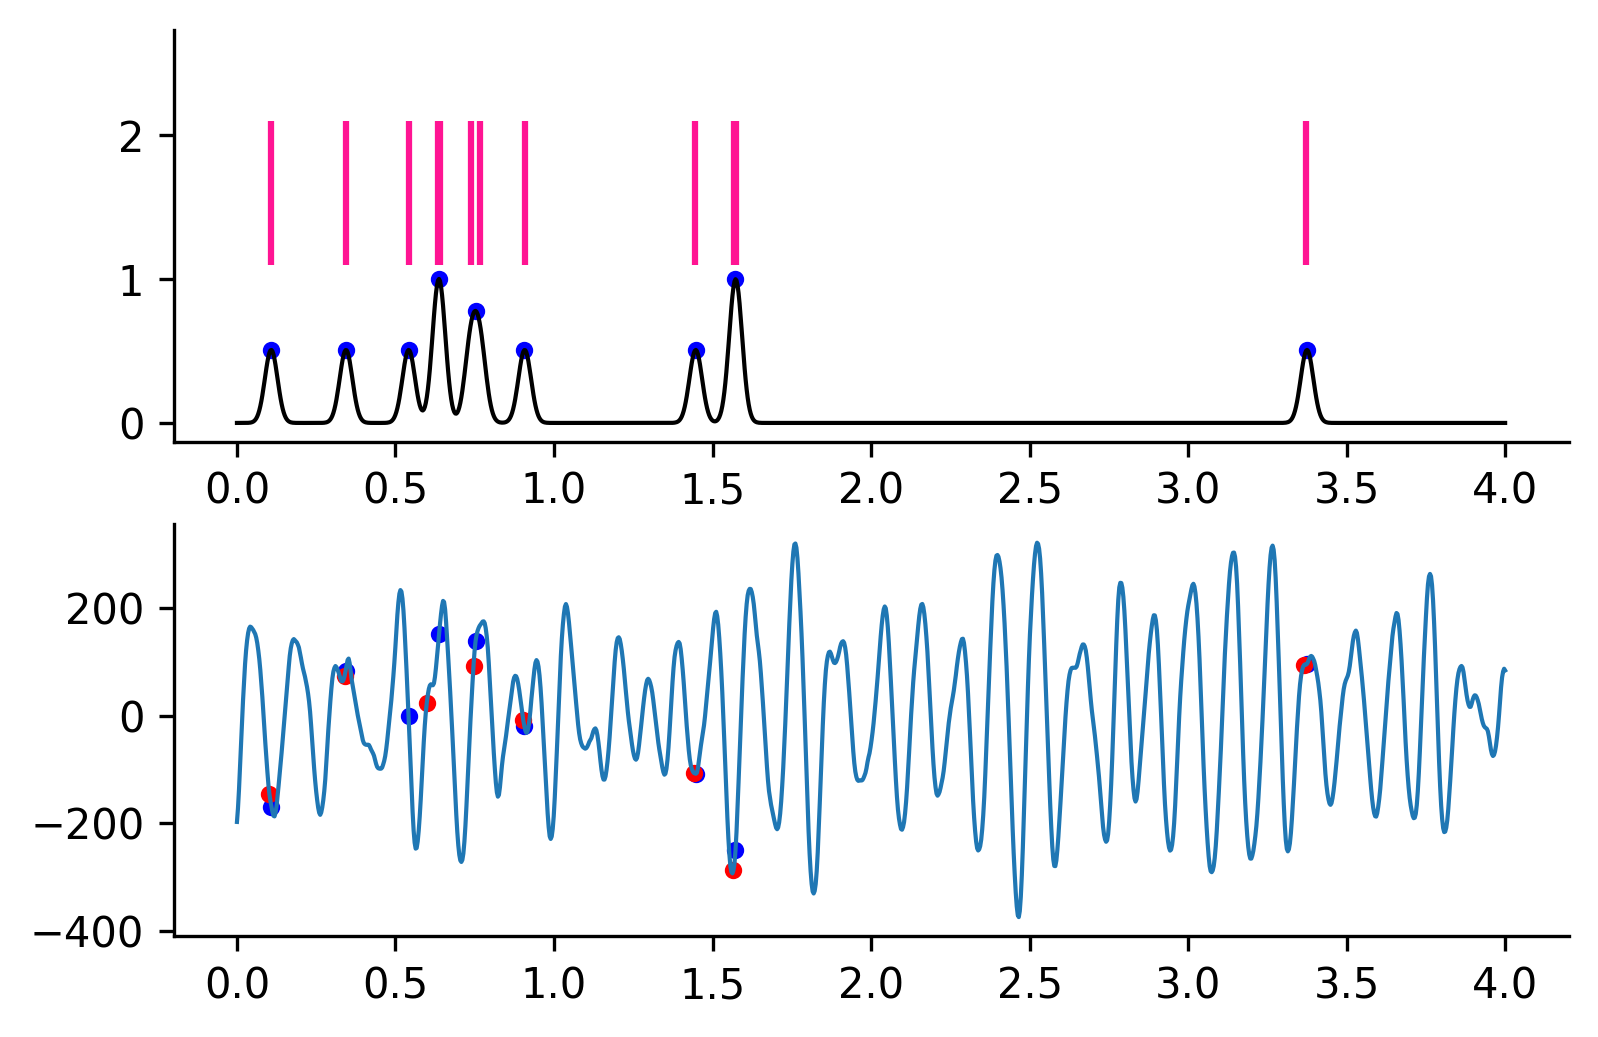

Neuron: 33.0, Label: Null
Trial: 7.0


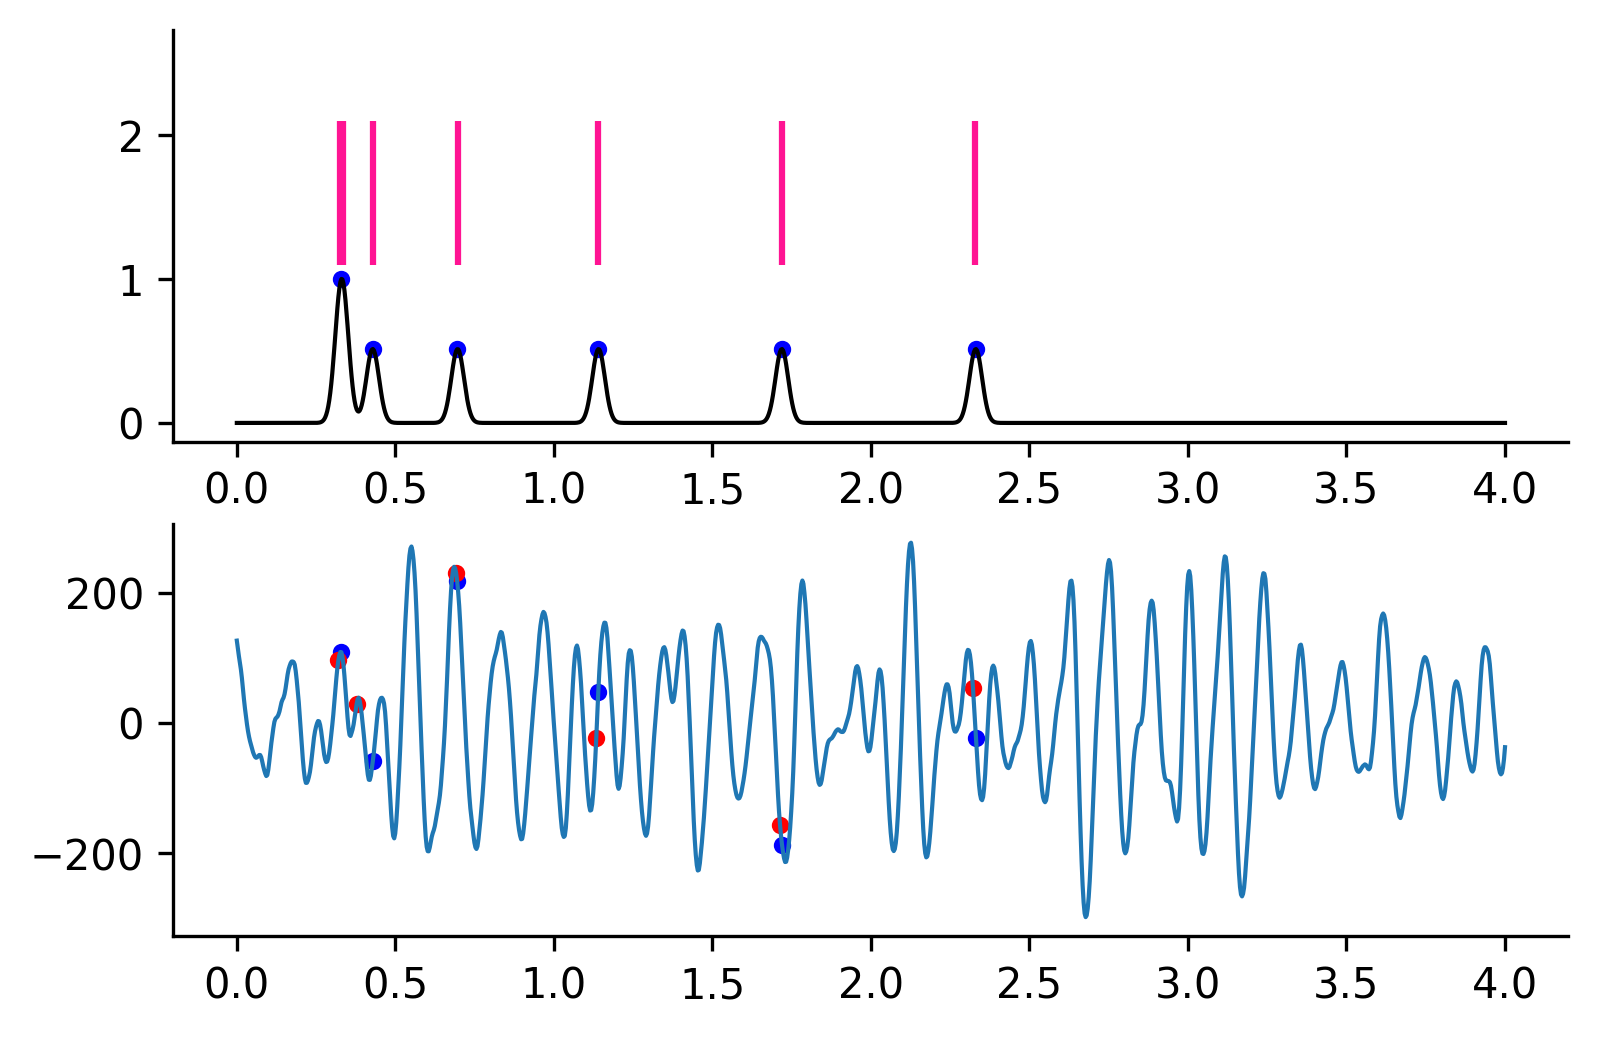

Neuron: 33.0, Label: Null
Trial: 8.0


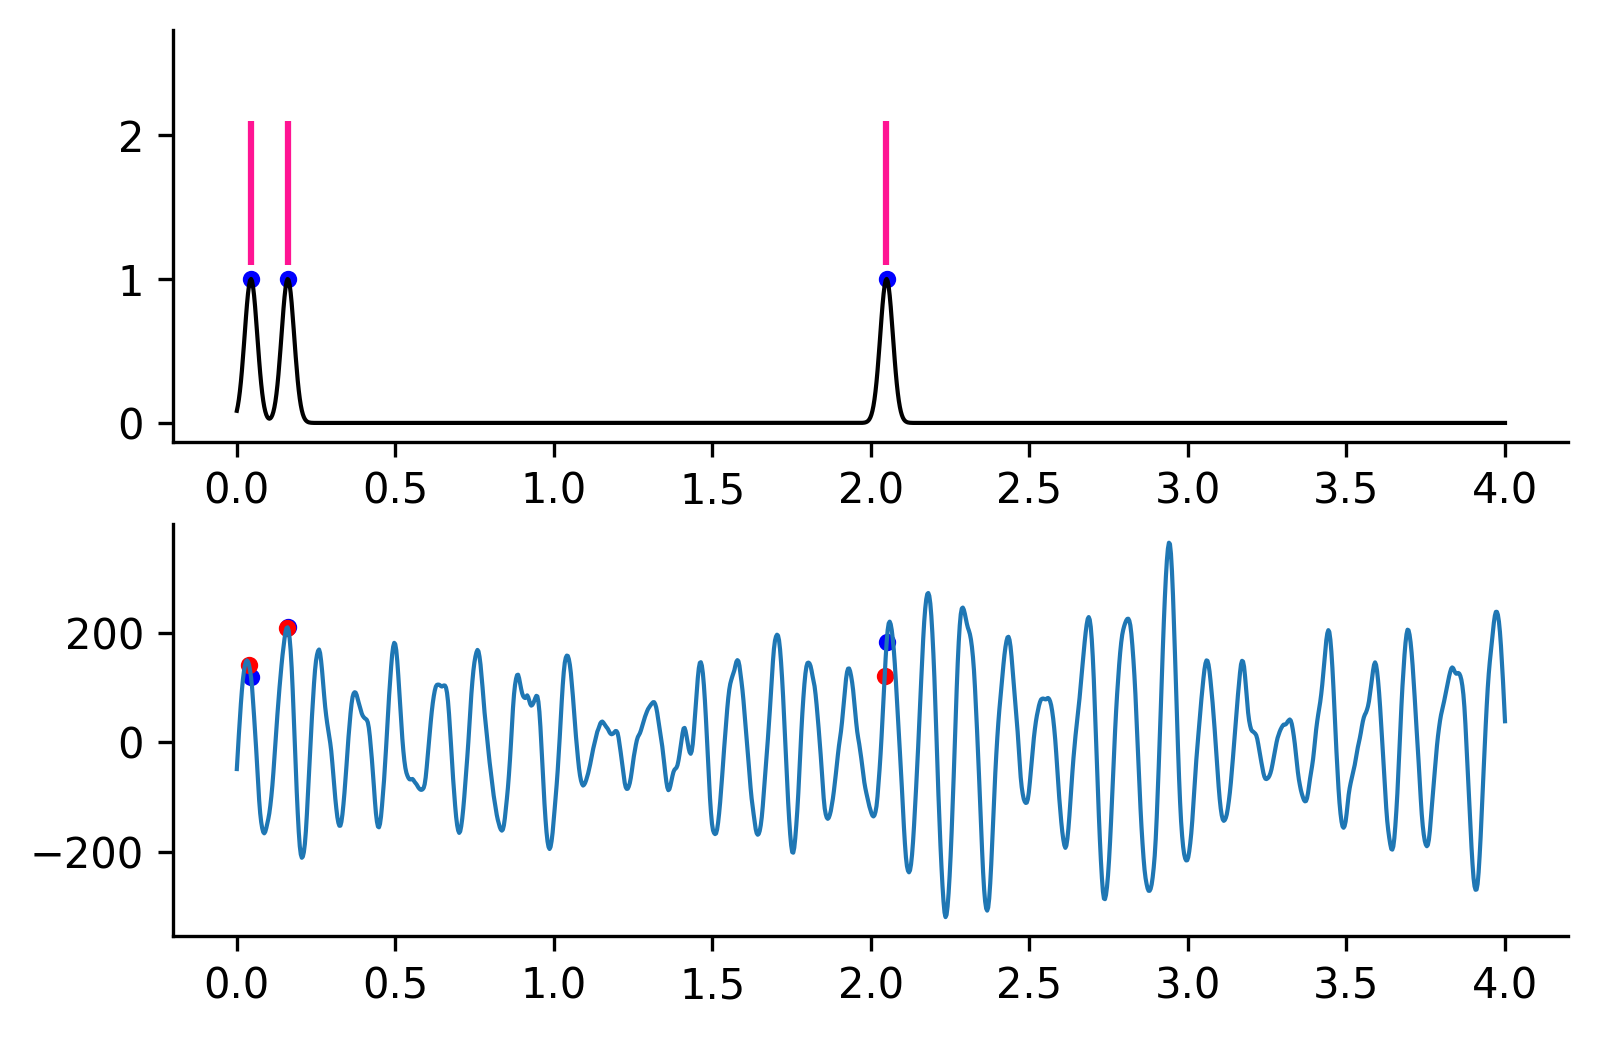

Neuron: 33.0, Label: Null
Trial: 9.0


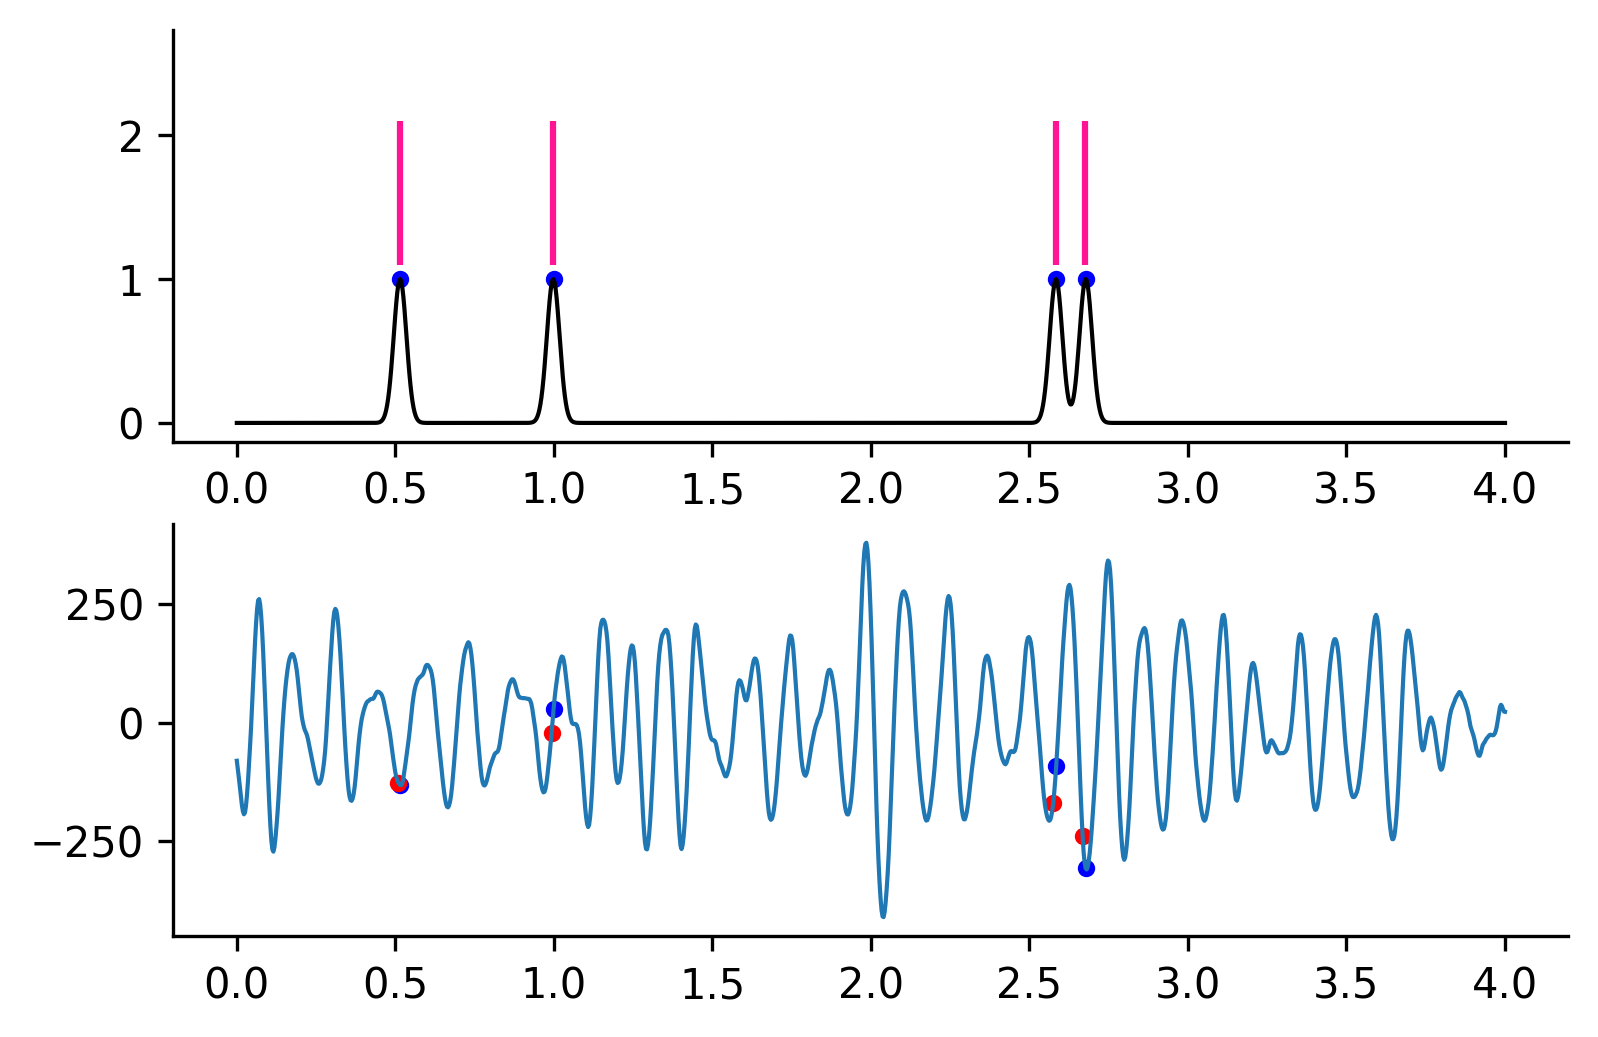

Neuron: 33.0, Label: Precession
Trial: 10.0


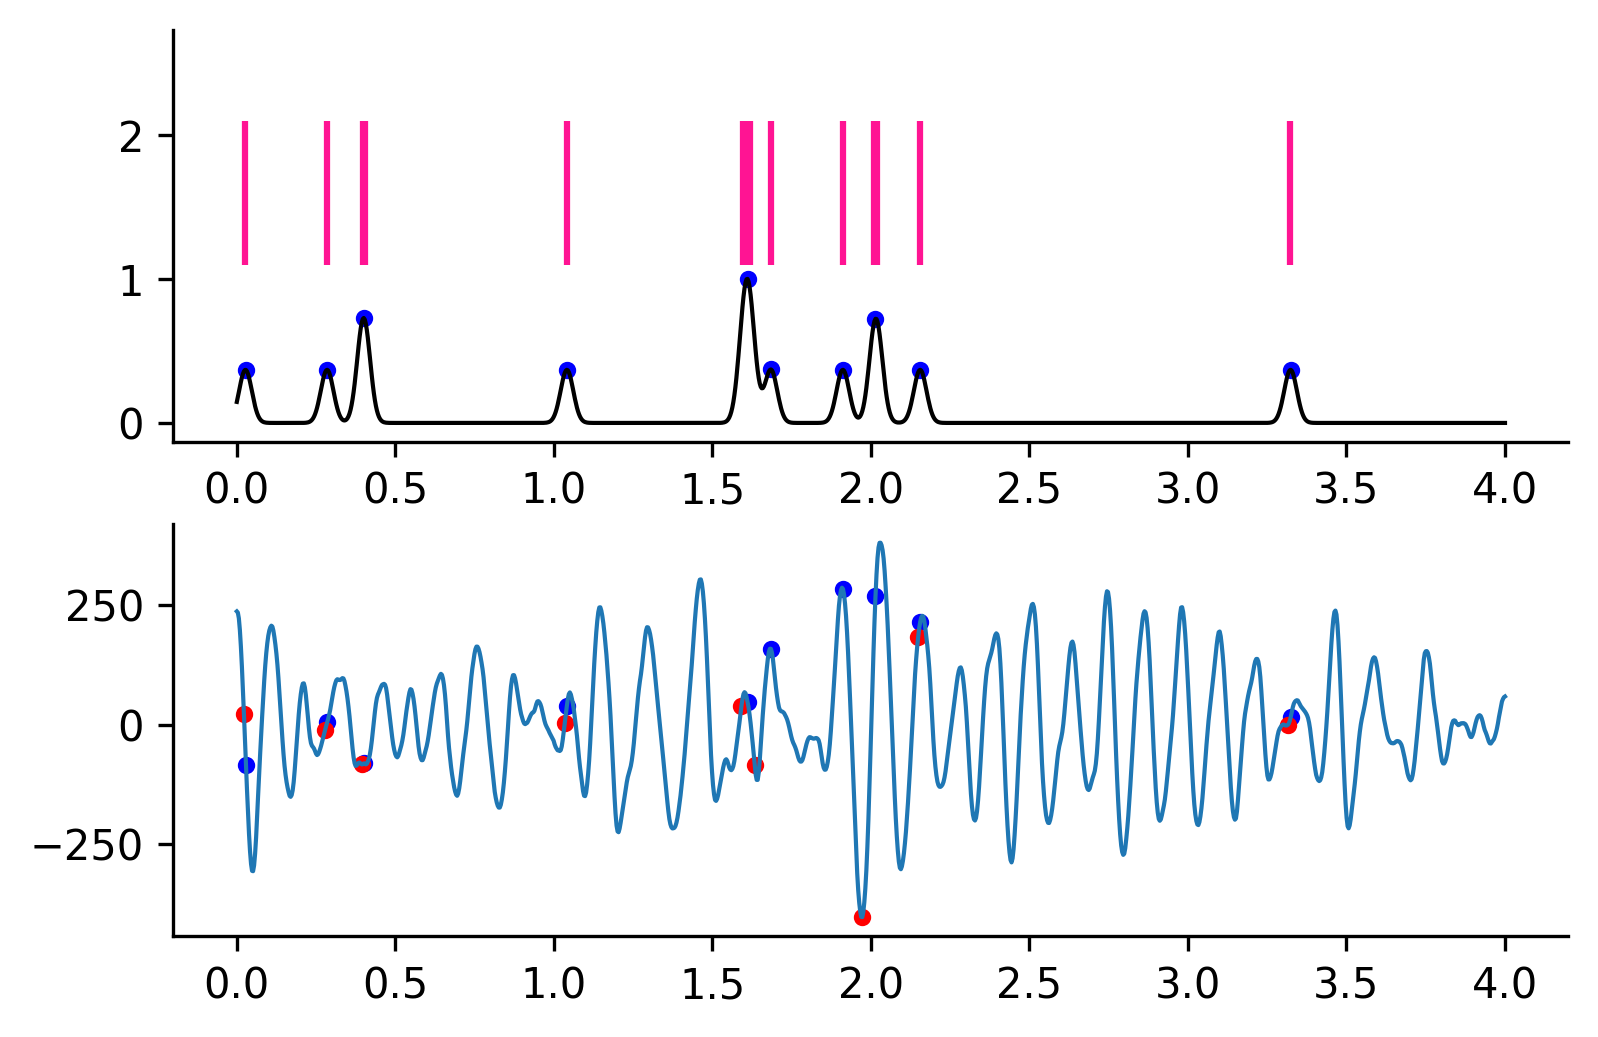

Neuron: 33.0, Label: Precession
Trial: 11.0


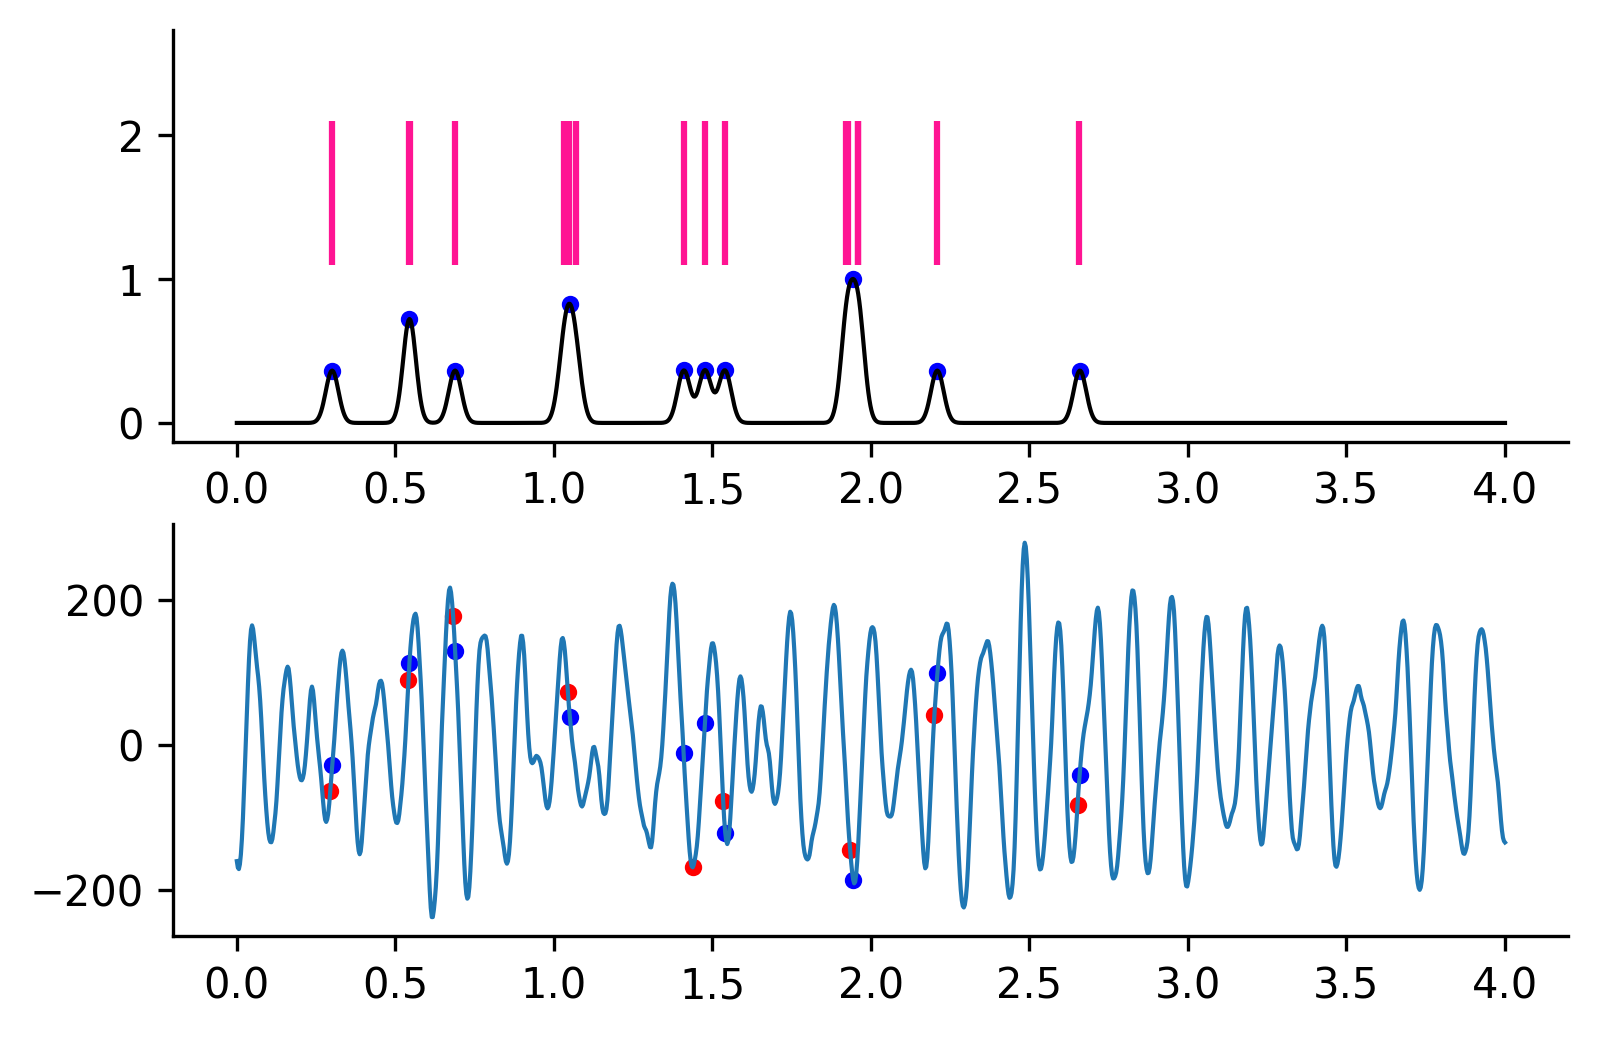

Neuron: 33.0, Label: Null
Trial: 12.0


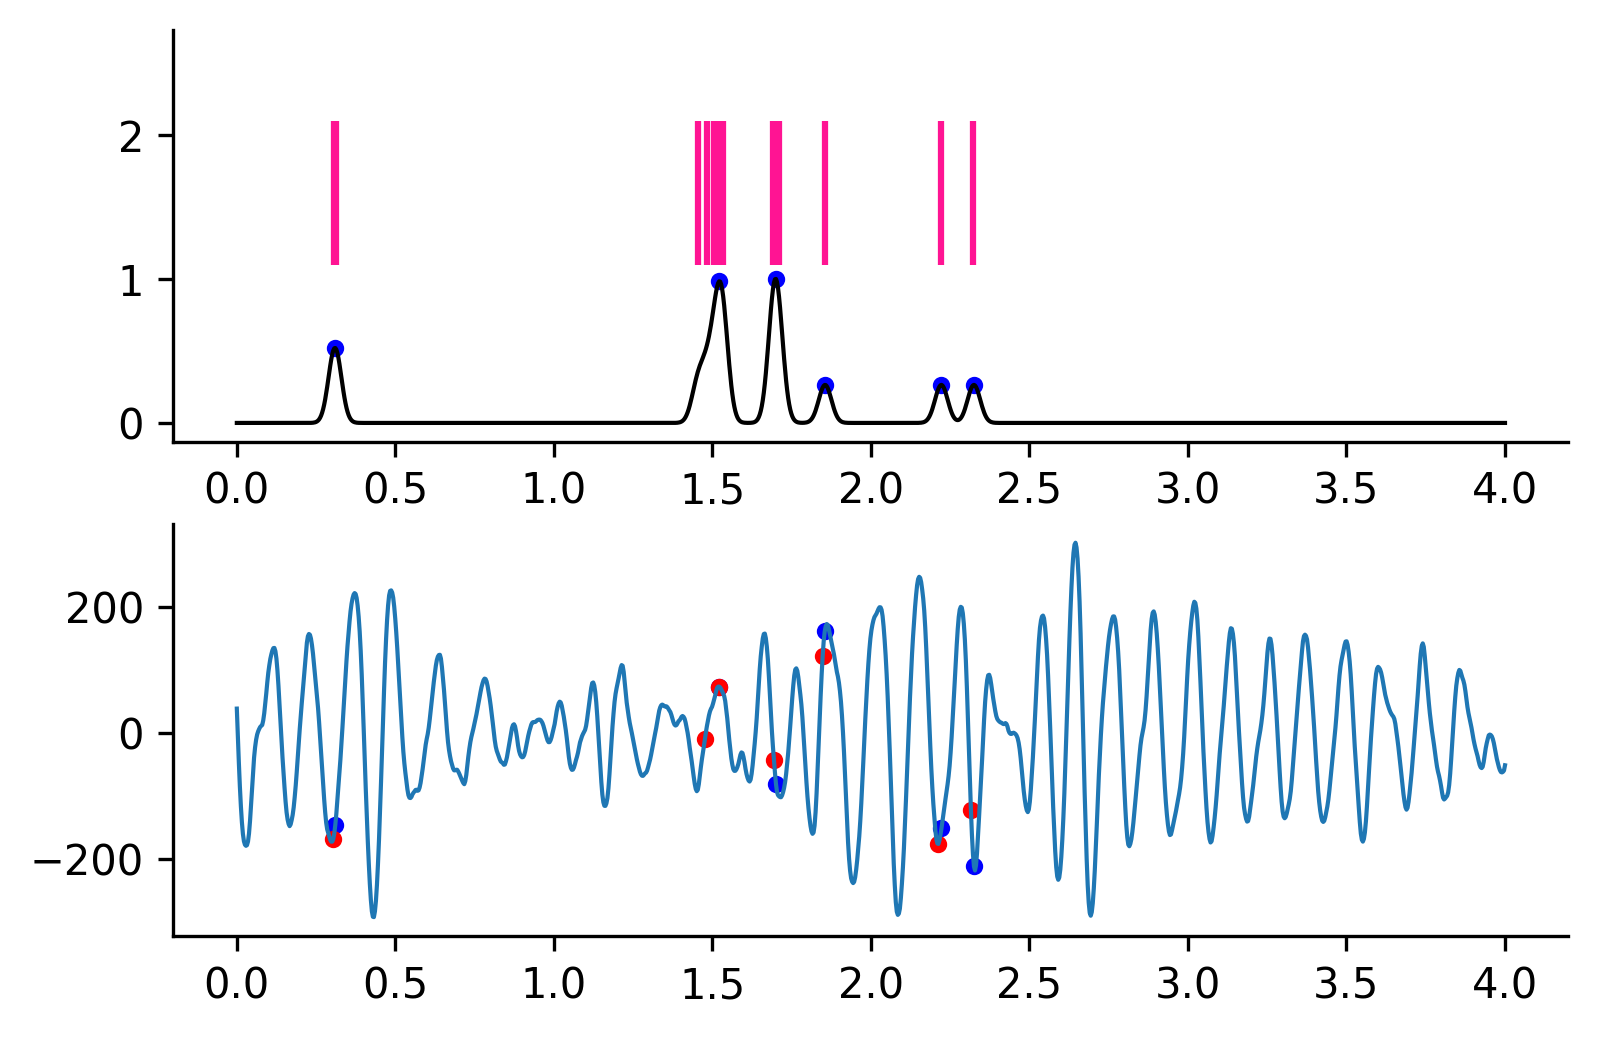

Neuron: 33.0, Label: Precession
Trial: 13.0


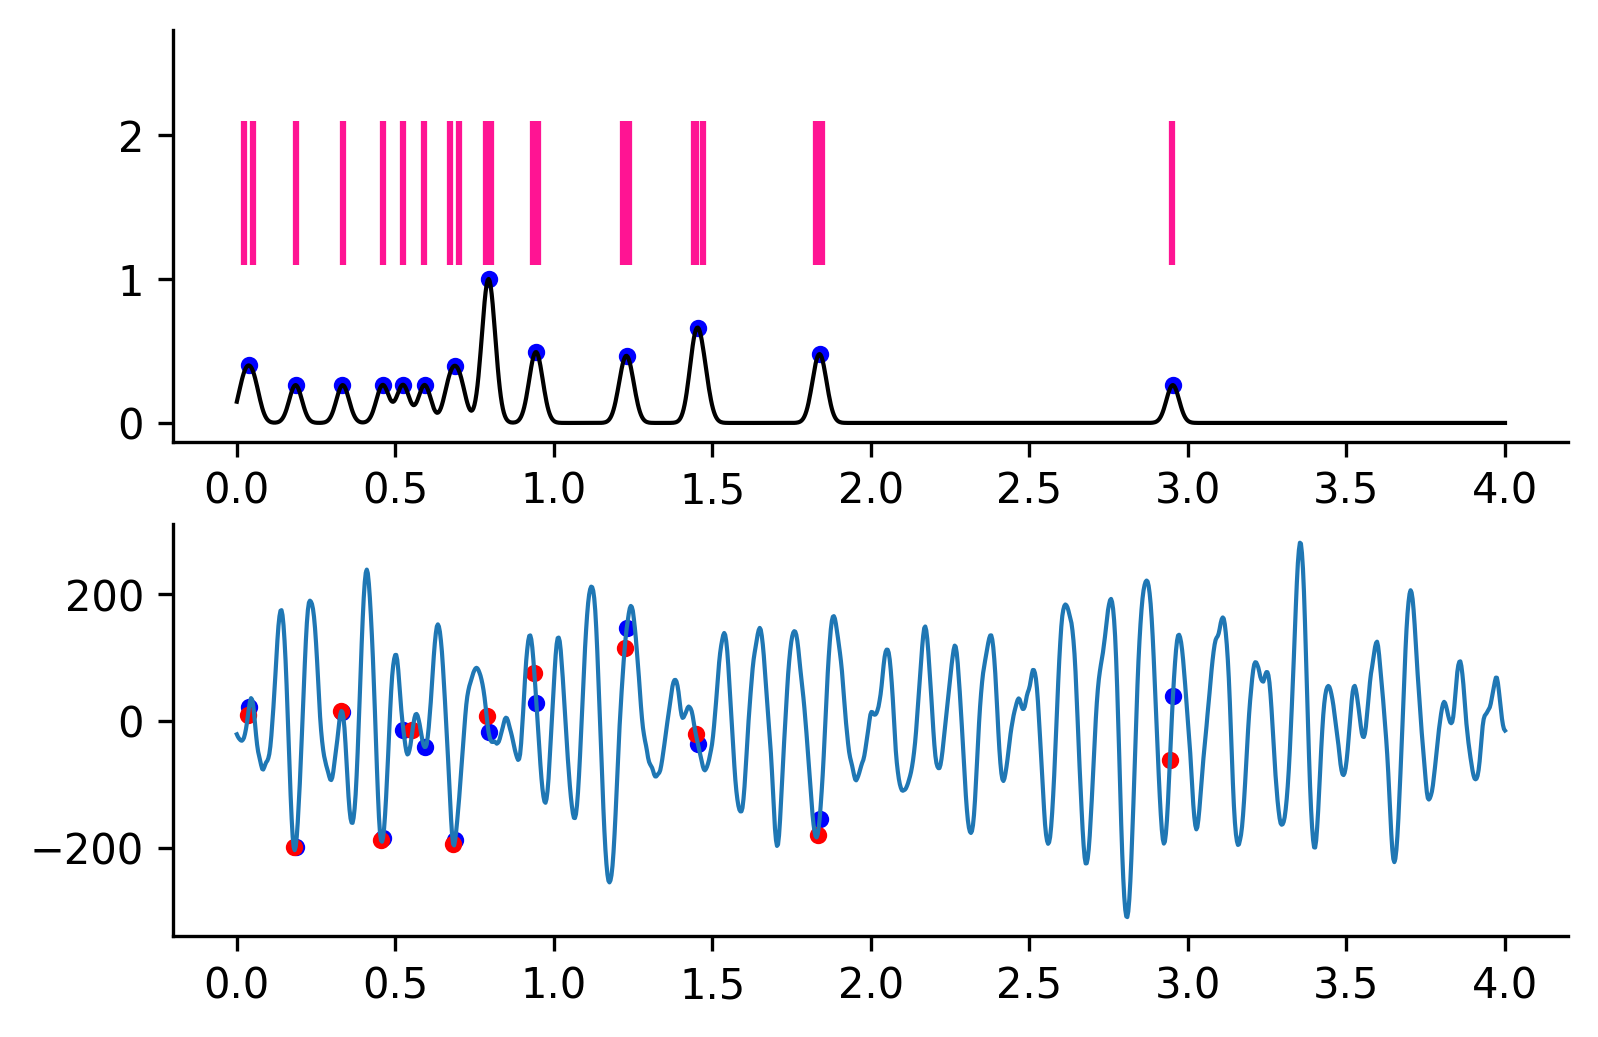

Neuron: 33.0, Label: Precession
Trial: 14.0


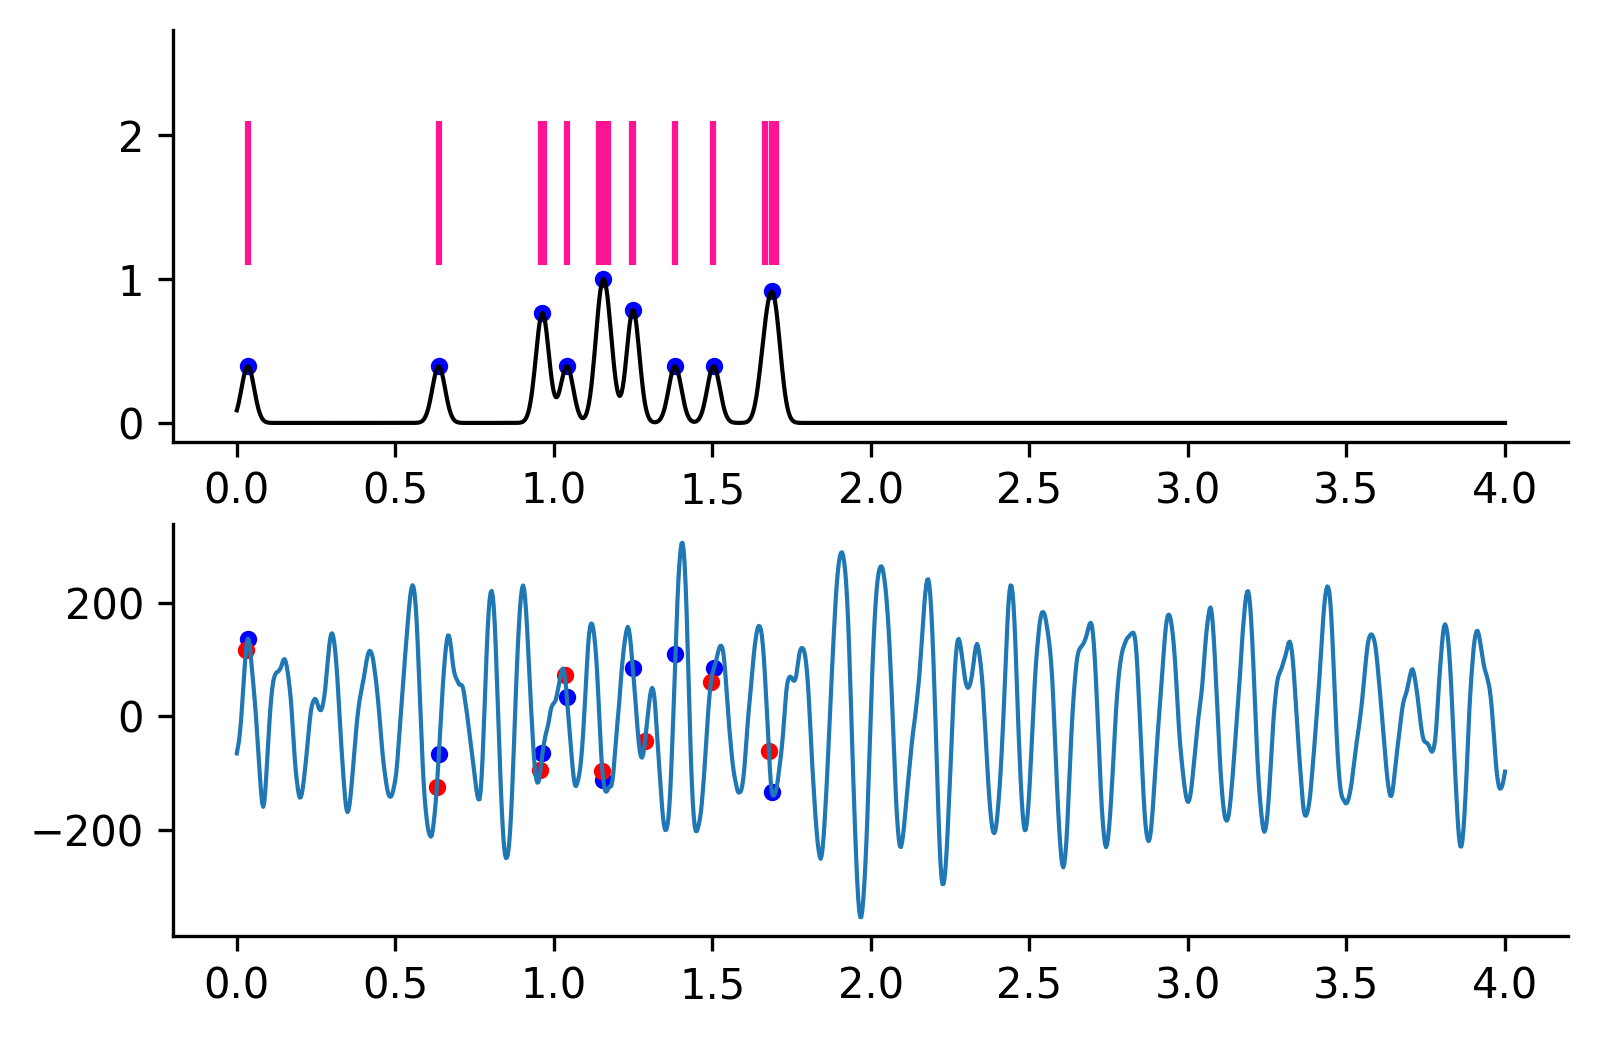

In [113]:
# a posteriori label confirmation
plt.rcParams['figure.dpi'] = 300

confirm_supervisor = True
neuron_of_interest = 33

if confirm_supervisor == True:
    time_axis = np.linspace(0, 4, num=X_kde.shape[1])
    for trial_row in np.where(np.array(pyr_sep_neuron_labels) == neuron_of_interest)[0]:  #range(X_kde.shape[0]):
        provisional_fs = int(X_kde.shape[1]/4)
        prq, CT_times = compute_PRQ(
            time_axis,
            X_theta[trial_row, :],
            pyr_sep_trials[trial_row],
            provisional_fs
        )
        string_label = 'Null'
        if Y[trial_row, 0] == 1:
            string_label = 'Precession'

        print(f'Neuron: {pyr_sep_neuron_labels[trial_row]}, Label: {string_label}')
        print(f'Trial: {pyr_sep_trial_labels[trial_row]}')

        fig, axes = plt.subplots(2, 1)
        fig.patch.set_alpha(0.0)
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        peak_indices = find_peaks(X_kde[trial_row, :], height=0.05*np.amax(X_kde[trial_row, :]), distance=0.06*fs)[0]
        theta_oscillation = X_theta[trial_row, :]
        kde = X_kde[trial_row, :]
        axes[0].plot(time_axis, kde, linewidth=1.0, color='k')
        axes[0].scatter(time_axis[peak_indices], kde[peak_indices], s=10, color='b')
        axes[0].eventplot(pyr_sep_trials[trial_row], color='deeppink', lineoffsets=1.6)
        axes[1].plot(time_axis, theta_oscillation, linewidth=1.0)
        axes[1].scatter(time_axis[peak_indices], theta_oscillation[peak_indices], s=10, color='b')
        axes[1].scatter(time_axis[np.array([int(x*provisional_fs) for x in CT_times])], theta_oscillation[np.array([int(x*provisional_fs) for x in CT_times])], s=10, color='r')

        plt.show()


In [ ]:
# Randomly permute the data
permutation = np.random.permutation(trial_kde.shape[0])
X_kde = X_kde[permutation, :]
X_theta = X_theta[permutation, :]

# Ensure that examples are uniformly distributed
num_precession = (np.where(Y[:, 0] == 1)[0]).size
head_rows = [] # Indices of non-precessing examples (rows) to be skimmed

# Loop over row-permuted array, noting the first n = (num_rows - 2*num_precess) non-precession labels
for i, label in enumerate(Y[:, 0]):
    if label == 1: 
        continue
    elif len(head_rows) < Y.shape[0] - 2*num_precession: 
        head_rows.append(i)
    else:
        break

# Delete the n rows from each of the data arrays, leaving (num_rows - num_rows + 2*num_precess) = num_precess rows
X_kde = np.delete(X_kde, head_rows, axis=0)
X_theta = np.delete(X_theta, head_rows, axis=0)
Y = np.delete(Y, head_rows, axis=0)

# Join the data into 1D
X_data = np.concatenate((X_kde, X_theta), axis=1)

# Create the test-train split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y, test_size=test_prop, random_state=test_train_seed)
print(f'Training data shape: {X_train.shape}')
print(f'Training label shape: {Y_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Testing label shape: {Y_test.shape}')

### Build model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

2022-05-13 16:31:39.550271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 16:31:39.550460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/R/lib:/usr/lib/jvm/java-17-openjdk/lib/server:
2022-05-13 16:31:39.550531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/R/lib:/usr/lib/jvm/java-17-openjdk/lib/server:
2022-05-13 16:31:39.550583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: 

### Train model

In [ ]:
history = model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
44/44 [==============================] - 1s 13ms/step - loss: 15.0767 - accuracy: 0.4780
Epoch 2/100
44/44 [==============================] - 1s 12ms/step - loss: 2.7243 - accuracy: 0.5119
Epoch 3/100
44/44 [==============================] - 1s 12ms/step - loss: 1.4082 - accuracy: 0.5191
Epoch 4/100
44/44 [==============================] - 1s 12ms/step - loss: 0.9181 - accuracy: 0.5394
Epoch 5/100
44/44 [==============================] - 1s 12ms/step - loss: 0.8812 - accuracy: 0.5451
Epoch 6/100
44/44 [==============================] - 1s 12ms/step - loss: 0.7607 - accuracy: 0.5588
Epoch 7/100
44/44 [==============================] - 1s 12ms/step - loss: 0.7094 - accuracy: 0.5718
Epoch 8/100
44/44 [==============================] - 1s 12ms/step - loss: 0.7308 - accuracy: 0.5516
Epoch 9/100
44/44 [==============================] - 1s 12ms/step - loss: 0.6999 - accuracy: 0.5690
Epoch 10/100
44/44 [==============================] - 1s 12ms/step - loss: 0.6995 - accuracy: 0.570

### Test model

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)

11/11 - 0s - loss: 0.7656 - accuracy: 0.5159 - 81ms/epoch - 7ms/step
